This project examines few months of data of a fictional startup.

Dilan is a world traveler and a solo entrepreneur. He writes a **travel blog** where he sells info products: an 8 dollar e-book (World Travelers' Best Practices) and an 80 dollar video course (How To Travel the World).

The project seeks the answers for these questions:
1. In which country should he prioritise his effort and why?
2. Any other advice to Dilan on how to be smart with his investments based on the data from the last 3 months?
3. Is there interesting information (beyond the above 2 questions) in the data from which Dilan could profit?

You can read more details on my github.

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

## Data preparation for analysis

In [2]:
# importing data

complete_dataset = pd.read_csv('dilans_data.csv', delimiter=';', names = ['event_date', 'event', 'country',
                                                                          'user_id', 'source', 'topic'])
complete_dataset

,event_date,event,country,user_id,source,topic
0,2018-01-01 00:01:01,read,country_7,2.458151e+09,SEO,North America
1,2018-01-01 00:03:20,read,country_7,2.458151e+09,SEO,South America
2,2018-01-01 00:04:01,read,country_7,2.458151e+09,AdWords,Africa
3,2018-01-01 00:04:02,read,country_7,2.458151e+09,AdWords,Europe
4,2018-01-01 00:05:03,read,country_8,2.458151e+09,Reddit,North America
...,...,...,...,...,...,...
597897,2018-03-31 04:34:32,read,country_4,2.458361e+09,Africa,NaN
597898,2018-03-31 05:02:06,read,country_6,2.458361e+09,Asia,NaN
597899,2018-03-31 05:02:14,read,country_7,2.458361e+09,North America,NaN
597900,2018-03-31 05:03:53,read,country_7,2.458361e+09,Europe,NaN


In [3]:
# I split the first column into date and time so it's easier to work with.

def date_time_split(data):
    
    # function creating a date and a time column from one datetime column
    new = data["event_date"].str.split(" ", n = 1, expand = True)
    data["event_date"]= new[0]
    data["event_time"]= new[1]

    data = data[['event_date','event_time','event','country','user_id','source','topic']]
    data['event_date'] = pd.to_datetime(data['event_date'])
    
    return data

In [4]:
# Using functin to split the columns

complete_dataset = date_time_split(complete_dataset)

In [5]:
complete_dataset.head()

,event_date,event_time,event,country,user_id,source,topic
0,2018-01-01,00:01:01,read,country_7,2.458151e+09,SEO,North America
1,2018-01-01,00:03:20,read,country_7,2.458151e+09,SEO,South America
2,2018-01-01,00:04:01,read,country_7,2.458151e+09,AdWords,Africa
3,2018-01-01,00:04:02,read,country_7,2.458151e+09,AdWords,Europe
4,2018-01-01,00:05:03,read,country_8,2.458151e+09,Reddit,North America


In [6]:
# I decided to remove the last day's data (2018-03-31) from the analysis as it is incomplete
# and only includes events between 00:00 and around 05:00 o'clock.

complete_dataset.drop(complete_dataset[complete_dataset['event_date'] == '2018-03-31'].index, inplace=True)

In [7]:
# Checking for null values and datatypes
complete_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597770 entries, 0 to 597769
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_date  597770 non-null  datetime64[ns]
 1   event_time  597770 non-null  object        
 2   event       597770 non-null  object        
 3   country     597770 non-null  object        
 4   user_id     590152 non-null  float64       
 5   source      581745 non-null  object        
 6   topic       210023 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 36.5+ MB


In [8]:
# A parent class that will help me with creating dataframes for analysis

class Metrics():
    
    def __init__(self, data):
        self.data = data
        
    def subscribers(self):
        
        # Function to create a dataframe for subscribers
        subscribers = self.data.loc[self.data['event']=='subscribe']
        subscribers = subscribers.drop(['user_id', 'source', 'topic'], axis=1)
        subscribers.columns = ['event_date','event_time', 'event', 'user_id',]
        subscribers['user_id'] = subscribers['user_id'].astype('float64')
        
        return subscribers
    
    def customers(self):
        
        # Function to create a dataframe for customers
        customers = self.data.loc[self.data.event=='buy']
        customers = customers.drop(['source', 'topic'], axis=1)
        customers.columns = ['event_date','event_time', 'event', 'user_id', 'revenue']
        customers.user_id = customers.user_id.astype('float64')
        
        return customers
    
    def readers(self):
        
        # Function to create a dataframe for readers
        readers = self.data.loc[self.data['event']=='read'].copy()

        # the topic and source columns are messy because of the later reads not showing source
        topics = ['Africa', 'Asia', 'Australia', 'Europe', 'North America', 'South America']

        for i in topics:
            readers.source, readers.topic = np.where(readers.source == i, [readers.topic, readers.source], [readers.source, readers.topic])
            
        return readers
    
    def daily_subs(self):
        
        # Function to create a dataframe for daily subscribers
        daily_subscribers = self.subscribers()[['event_date', 'event']].groupby('event_date').count()
        
        return daily_subscribers
    
    def daily_readers(self):
        
        # Function to create a dataframe for daily readers
        daily_readers = self.readers()[['event_date', 'event']].groupby('event_date').count()

        return daily_readers
    
    def daily_customers(self):
        
        # Function to create a dataframe for daily customers
        daily_customers = self.customers()[['event_date', 'user_id']].groupby('event_date').nunique()
        
        return daily_customers
    
    def daily_revenue(self):
        
        # Function to create a dataframe for subscribers
        daily_rev = self.customers()[['event_date', 'revenue']].groupby('event_date').sum()
        daily_book_rev = self.customers().loc[self.customers()['revenue'] == 8].drop(['event_time', 'event', 'user_id'], axis=1).groupby('event_date').sum().reset_index()
        daily_course_rev = self.customers().loc[self.customers()['revenue'] == 80].drop(['event_time', 'event', 'user_id'], axis=1).groupby('event_date').sum().reset_index()
        
        daily_rev_summary = daily_rev.merge(daily_book_rev, how='outer', on = 'event_date')
        daily_rev_summary = daily_rev_summary.merge(daily_course_rev, how='outer', on='event_date')
        daily_rev_summary = daily_rev_summary.set_index(["event_date"])
        daily_rev_summary.columns = ['revenue', 'book_rev', 'course_rev']
        
        return daily_rev_summary
    
    def daily_activity(self):
        
        # Function to create a dataframe for subscribers
        daily_active_users = self.data[['event_date', 'user_id',]].groupby('event_date').nunique('user_id')
        
        return daily_active_users
    
    def horizontal_barplot(self, data, title, xcol, ycol, palette):
        
        # Function to visualize the metrics with a barplot
        fig = plt.figure(figsize=(6,4), dpi=100)
        axes = fig.add_axes([0.1,0.1,0.9,0.9])
        axes.set_title(title)
        sns.barplot(y=ycol, x=xcol,data=data, orient='h', palette=palette)
        
    def conversion_rate(self, dividend_data, divisor_data, merge_on, dividend_col, divisor_col):
        
        # Function that returns a df with a column that shows the conversion rate 
        c_rate = dividend_data.merge(divisor_data, on=merge_on, how="inner")
        c_rate["Conversion"] = c_rate[dividend_col].divide(c_rate[divisor_col], axis=0)
        
        return c_rate
    
    def pie_chart(self,data, title, legend_data):
        
        fig = plt.figure(figsize=(6,4), dpi=100)
        axes = fig.add_axes([0.1,0.1,0.9,0.9])
        axes.set_title(title)

        plt.pie(data, autopct="%1.0f%%")
        plt.legend(legend_data, loc="right", bbox_to_anchor=(1,0,0.5,1))
        
    def segmentation(self):
    
        source = self.readers()[['user_id', 'source']].drop_duplicates(subset='user_id')
        country = self.readers()[['user_id', 'country']].drop_duplicates(subset='user_id')
        segments = self.customers().merge(country, on='user_id')
        segments = segments.merge(source, on='user_id')
        segments = segments.groupby(['country', 'source']).revenue.sum().sort_values(ascending=False)
        segments = segments.to_frame().reset_index()
        segments.columns = ['Country', 'Source', 'Revenue']
        
        return segments

In [9]:
# Creating a child class for some visualizations

class Metric_Visuals(Metrics):
    
    def __init__(self, data):
        super().__init__(data)
        
    def visualize(self, data, title, xlabel, ylabel, facecolor, plot_color, grid=True):
        
        fig_1 = plt.figure(figsize=(6,4), dpi=100)
        axes_1 = fig_1.add_axes([0.1,0.1,0.9,0.9])
        axes_1.set_xlabel(xlabel)
        axes_1.set_ylabel(ylabel)
        axes_1.set_title(title)
        axes_1.set_facecolor(facecolor)
        
        if grid == True:
            axes_1.grid(True, dashes=(5,2,1,2))
        
        plt.plot(data, color=plot_color)
        fig_1.autofmt_xdate()
        
    def revenue_viz(self, data, title, xlabel, ylabel, facecolor):
        
        fig_2 = plt.figure(figsize=(6,4), dpi=100)
        axes_2 = fig_2.add_axes([0.1,0.1,0.9,0.9])
        axes_2.set_xlabel(xlabel)
        axes_2.set_ylabel(ylabel)
        axes_2.set_title(title)
        axes_2.grid(True, dashes=(5,2,3,1))
        axes_2.set_facecolor(facecolor)

        plt.plot(data)
        fig_2.autofmt_xdate()
        plt.legend(data, loc="right", bbox_to_anchor=(1,0,0.5,1))

In [10]:
# Creating an instance for class Metric_Visuals

travel_data = Metric_Visuals(complete_dataset)

## Exploratory data analysis

#### Daily readers

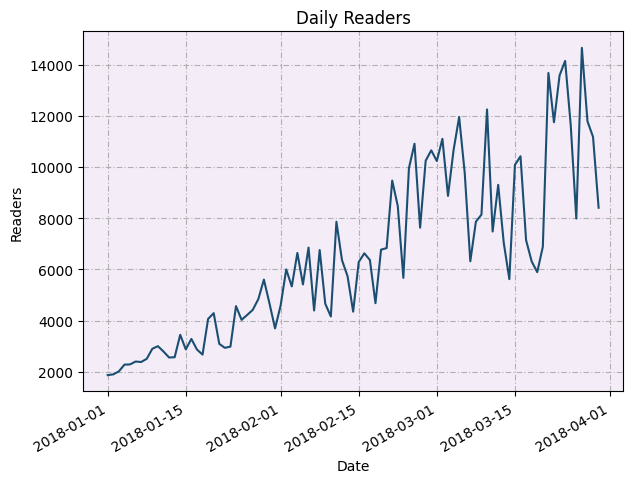

In [11]:
travel_data.visualize(travel_data.daily_readers(), 'Daily Readers', "Date", "Readers", "#F4ECF7", "#1B4F72")

#### Daily subscribers

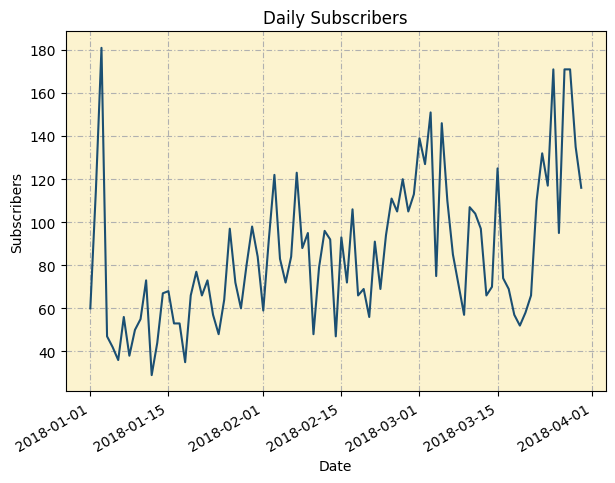

In [12]:
travel_data.visualize(travel_data.daily_subs(), 'Daily Subscribers', "Date", "Subscribers", "#FCF3CF", "#1B4F72")

#### Daily customers

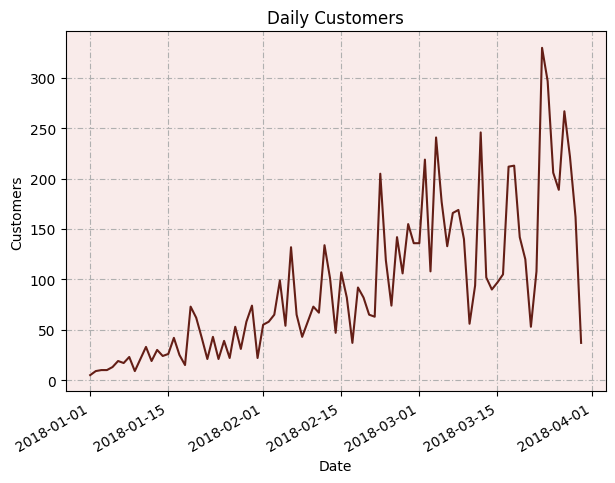

In [13]:
travel_data.visualize(travel_data.daily_customers(), 'Daily Customers', "Date", "Customers", "#F9EBEA", "#641E16")

## Key Metrics

#### Daily revenue

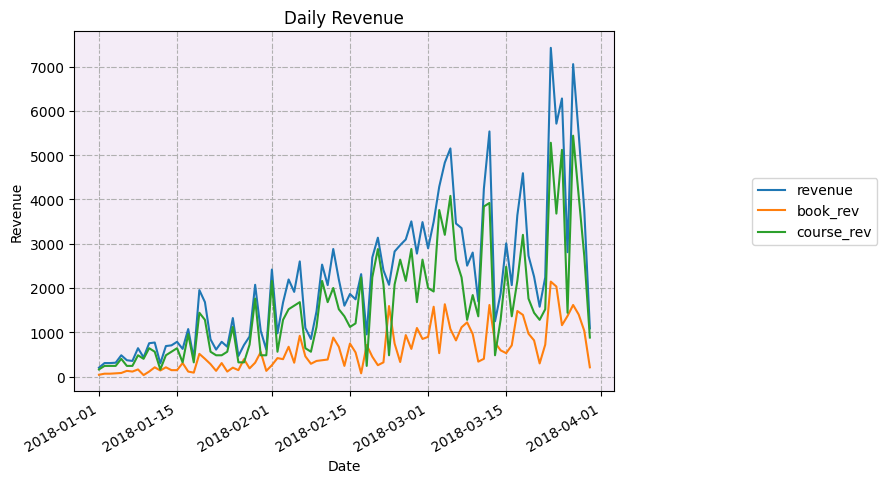

In [14]:
travel_data.revenue_viz(travel_data.daily_revenue(), 'Daily Revenue', "Date", "Revenue", "#F4ECF7")

#### Daily activity

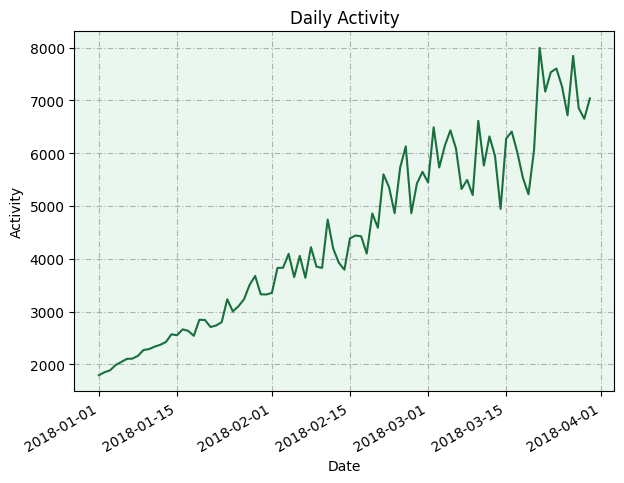

In [15]:
travel_data.visualize(travel_data.daily_activity(), 'Daily Activity', "Date", "Activity", "#E9F7EF", "#196F3D")

## Funnel

In [42]:
class Funnel(Metrics):
    
    # This class contains all the important functions to create a funnel analysis
    def __init__(self, data):
        super().__init__(data)
        
    def funnel_parts(self):
        
        # Function to create the parts of the funnel visualization
        first_readers = self.readers().loc[self.readers().source.notnull()].user_id.count()
        returning_readers = self.readers().loc[self.readers().source.isnull()].user_id.nunique()
        sub_funnel = len(self.subscribers().index)
        book_funnel = self.customers().loc[self.customers()['revenue']== 8].user_id.count()
        course_funnel = self.customers().loc[self.customers()['revenue']== 80].user_id.count()
        funnel = pd.DataFrame({'first_readers' : [first_readers], 'returning_readers' : [returning_readers], 'subscribers' : [sub_funnel],
                      'bought_book' : [book_funnel], 'bought_course' : [course_funnel]})
        
        return funnel
    
    def funnel_viz(self, dataset, cpalette):
        
        # Function that creates a visualization of the funnel
        fig = plt.figure(figsize=(6,4), dpi=100)
        axes = fig.add_axes([0.1,0.1,0.9,0.9])
        axes.set_title("Funnel Analysis")
        sns.barplot(data=dataset, orient = 'h', palette=cpalette)

In [43]:
# Creating instance for the Funnel class 

travel_funnel = Funnel(complete_dataset)

In [40]:
travel_funnel.funnel_parts()

,first_readers,returning_readers,subscribers,bought_book,bought_course
0,210023,66099,7618,6640,1767


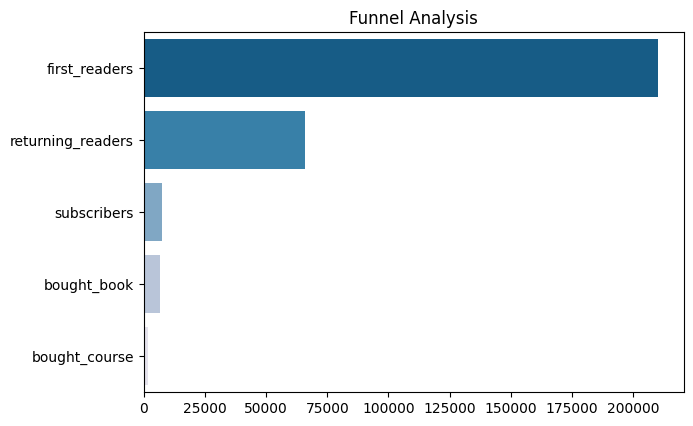

In [46]:
# visualizing funnel

travel_funnel.funnel_viz(travel_funnel.funnel_parts(), 'PuBu_r')

## Country analysis

#### Important metrics

In [19]:
class CountryAnalysis(Metrics):
    
    # This class contains all the important functions to analyze the country feature
    def __init__(self, data):
        super().__init__(data)
        
    def customers_by_country(self):
        
        # This function creates a dataframe that shows how many customers we have in each country
        customers_by_country = self.readers().merge(self.customers(), on='user_id', how='outer')
        customers_by_country = customers_by_country.loc[customers_by_country.event_y == 'buy']
        customers_by_country = customers_by_country.groupby('country').user_id.nunique().sort_values(ascending=False)
        customers_by_country = customers_by_country.to_frame().reset_index()
        customers_by_country.columns = ['Country', 'Customers']
        
        return customers_by_country
    
    def revenue_by_country(self):
        
        # This function creates a dataframe that shows how much revenue the company gets from each country
        country = self.readers()[['user_id', 'country']].drop_duplicates(subset='user_id')
        rev_by_country = self.customers().merge(country, on='user_id', how='inner')
        rev_by_country = rev_by_country.groupby('country').revenue.sum().sort_values(ascending=False).reset_index()
        rev_by_country.columns = ['Country', 'Revenue']
        
        return rev_by_country
    
    def readers_by_country(self):
        
        # Function that shows the number of readers in each country
        readers_country = self.readers().groupby('country').user_id.nunique().sort_values(ascending=False)
        readers_country = readers_country.to_frame().reset_index()
        readers_country.columns = ['Country', 'Readers']
        
        return readers_country

In [20]:
# Creating instance for class Country
country_data = CountryAnalysis(complete_dataset)

#### Revenue by country

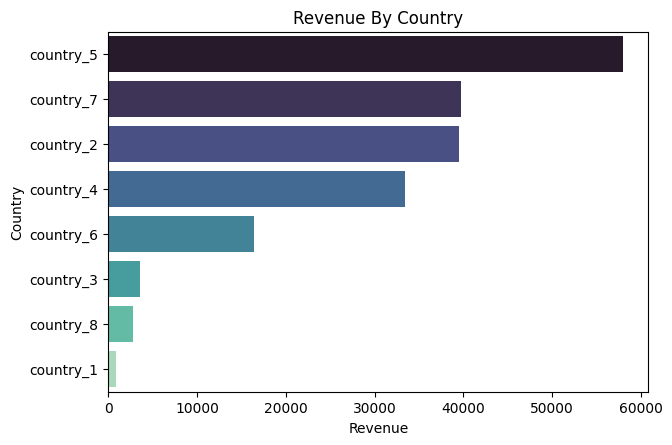

In [21]:
# Using function from the Metrics class to visualize the profitability of each country

country_data.horizontal_barplot(country_data.revenue_by_country(), "Revenue By Country", "Revenue", "Country", "mako")

#### Customers by country

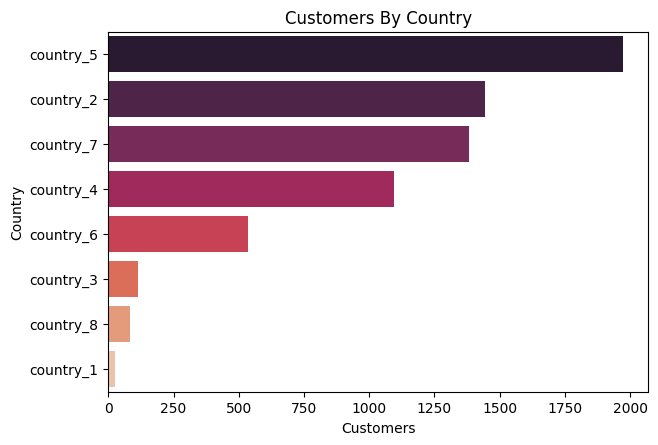

In [22]:
# Using function from the Metrics class to visualize the number of customers from each country

country_data.horizontal_barplot(country_data.customers_by_country(), "Customers By Country", "Customers", "Country", "rocket")

#### Readers by country

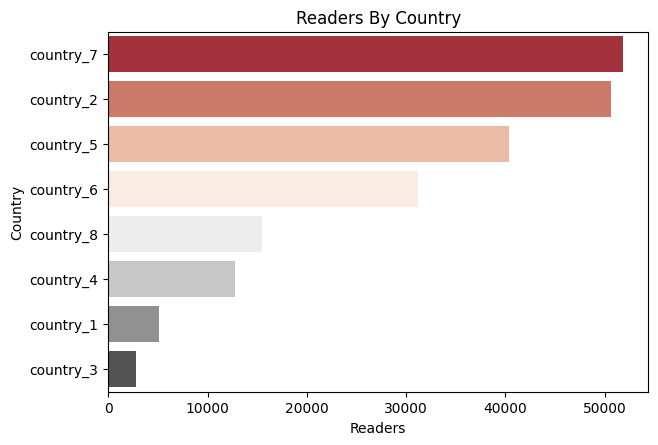

In [23]:
# Using function from the Metrics class to visualize the number of readers from each country

country_data.horizontal_barplot(country_data.readers_by_country(), "Readers By Country", "Readers", "Country", "RdGy")

#### Country conversion rates

In [24]:
# Dataframe with a calculated conversion rate column
country_c_rate = country_data.conversion_rate(country_data.customers_by_country(), country_data.readers_by_country(),\
                                              "Country", "Customers", "Readers").sort_values(by="Conversion", ascending=False)

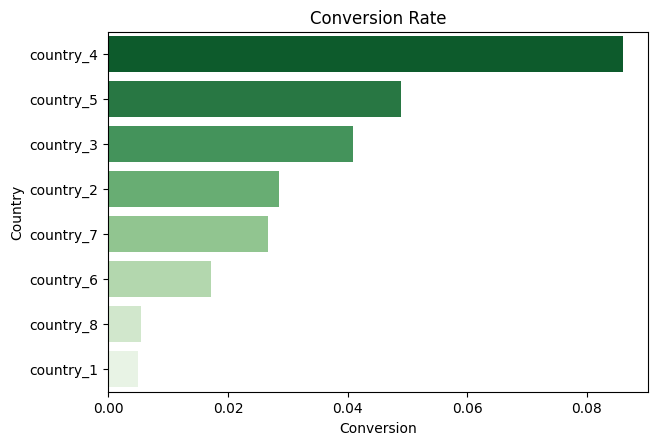

In [25]:
# Using function from the Metrics class to visualize the conversion rate of each country

country_data.horizontal_barplot(country_c_rate,"Conversion Rate", "Conversion", "Country", "Greens_r")

## Topic analysis

#### Important metrics

In [26]:
class TopicAnalysis(Metrics):
    
    # This class contains all the important functions to analyze the topic feature
    def __init__(self, data):
        super().__init__(data)
    
    def customers_by_topic(self):
        
        # Creates a df that shows which topics are read by customers
        cust_by_topic = self.readers().merge(self.customers(), on='user_id', how='inner')
        cust_by_topic = cust_by_topic.loc[cust_by_topic.event_y == 'buy'].groupby('topic').user_id.nunique().sort_values(ascending=False)
        cust_by_topic = cust_by_topic.to_frame().reset_index()
        cust_by_topic.columns=['Topic', 'Customers']
        
        return cust_by_topic
    
    def readers_by_topic(self):
        
        # Creates a df that shows which topics are read
        readers_top = self.readers().groupby('topic').user_id.count().sort_values(ascending=False).reset_index()
        readers_top.columns = ['Topic', "Readers"]
        
        return readers_top
    
    def returning_readers_by_topic(self):
        
        # Creates a df that shows which topics are read by returning readers
        ret_readers_top = self.readers()[self.readers().source.isnull()].groupby('topic').user_id.count().sort_values(ascending=False).reset_index()
        ret_readers_top.columns = ["Topic", "Returning Readers"]
        
        return ret_readers_top
    
    def average_topics(self):
        
        # Creates a tuple that contains the average number of topics customers and readers read
        cust_by_topic = self.readers().merge(self.customers(), on='user_id', how='inner')
        cust_mean = cust_by_topic.groupby('user_id').topic.nunique().mean()
        readers_mean = self.readers().groupby('user_id').topic.nunique().mean()
        
        return cust_mean, readers_mean

In [27]:
# Creating instance for the TopicAnalysis  class

topic_data = TopicAnalysis(complete_dataset)

#### Customers by topic

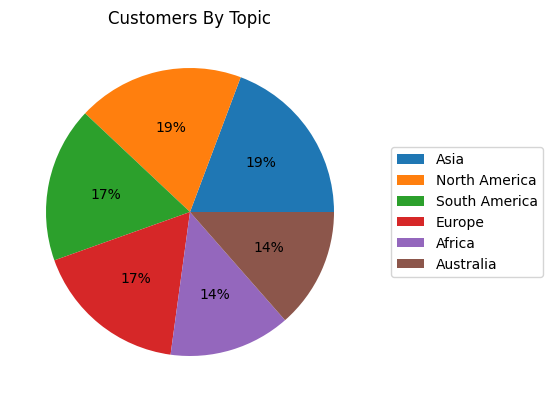

In [28]:
# Using the pie chart function from the parent class to visualize which topics are read by customers

topic_data.pie_chart(topic_data.customers_by_topic()["Customers"], "Customers By Topic", topic_data.customers_by_topic()["Topic"])

#### Readers by topic

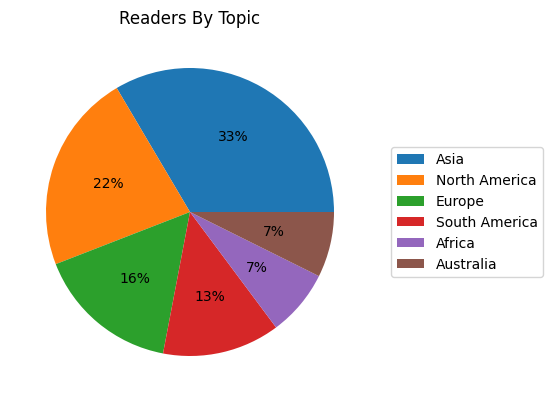

In [29]:
# Using the pie chart function from the parent class to visualize which topics are the most read

topic_data.pie_chart(topic_data.readers_by_topic()["Readers"], "Readers By Topic", topic_data.readers_by_topic()["Topic"])

#### Returning readers by topic

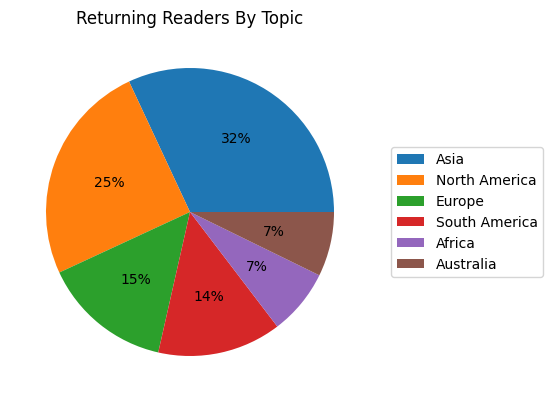

In [30]:
# Using the pie chart function from the parent class to visualize which topics are the most read by returning readers

topic_data.pie_chart(topic_data.returning_readers_by_topic()["Returning Readers"], "Returning Readers By Topic", topic_data.returning_readers_by_topic()["Topic"])

#### Average topics

In [31]:
# How many topics on average do customers and readers read (from 6)?

topic_data.average_topics()

(5.107701564380265, 1.6833965803745303)

## Source analysis

In [32]:
class SourceAnalysis(Metrics):
    
    # This class contains all the functions to analyze the source feature of the data
    
    def __init__(self, data):
        super().__init__(data)
        
    def customers_by_source(self):
        
        # This function creates a df that shows how many customers the company got from each source
        cust_source = self.readers().merge(self.customers(), on='user_id', how='inner')
        cust_source = cust_source.loc[cust_source.event_y == 'buy'].groupby('source').user_id.nunique().sort_values(ascending=False)
        cust_source = cust_source.to_frame().reset_index()
        cust_source.columns = ["Source", "Customers"]
        
        return cust_source
    
    def revenue_by_source(self):
        
        #This function creates a df that shows how much revenue the company got from each source
        rev_source = self.customers().merge(self.readers(), on='user_id', how='inner')
        rev_source = rev_source.groupby('source').revenue.sum().sort_values(ascending=False)
        rev_source = rev_source.to_frame().reset_index()
        rev_source.columns = ["Source", "Revenue"]
        
        return rev_source
    
    def readers_by_source(self):
        
        # This function creates a df that shows how many readers the company got from each source
        readers_source = self.readers()[['source', 'user_id']].groupby('source').user_id.nunique().sort_values(ascending=False)
        readers_source = readers_source.to_frame().reset_index()
        readers_source.columns = ["Source", "Readers"]
        
        return readers_source
    
    def subscribers_by_source(self):
        
        # This function creates a df that shows how many subscribers the company got from each source
        sub_source = self.subscribers().merge(self.readers(), on='user_id', how='inner')
        sub_source = sub_source.groupby('source').user_id.nunique().sort_values(ascending=False)
        sub_source = sub_source.to_frame().reset_index()
        sub_source.columns = ["Source", "Subscribers"]
        
        return sub_source

In [33]:
# Creating an instance for the class SourceAnalysis
source_data = SourceAnalysis(complete_dataset)

#### Visualizing key metrics for source

Text(0.5, 1.0, 'Subscribers By Source')

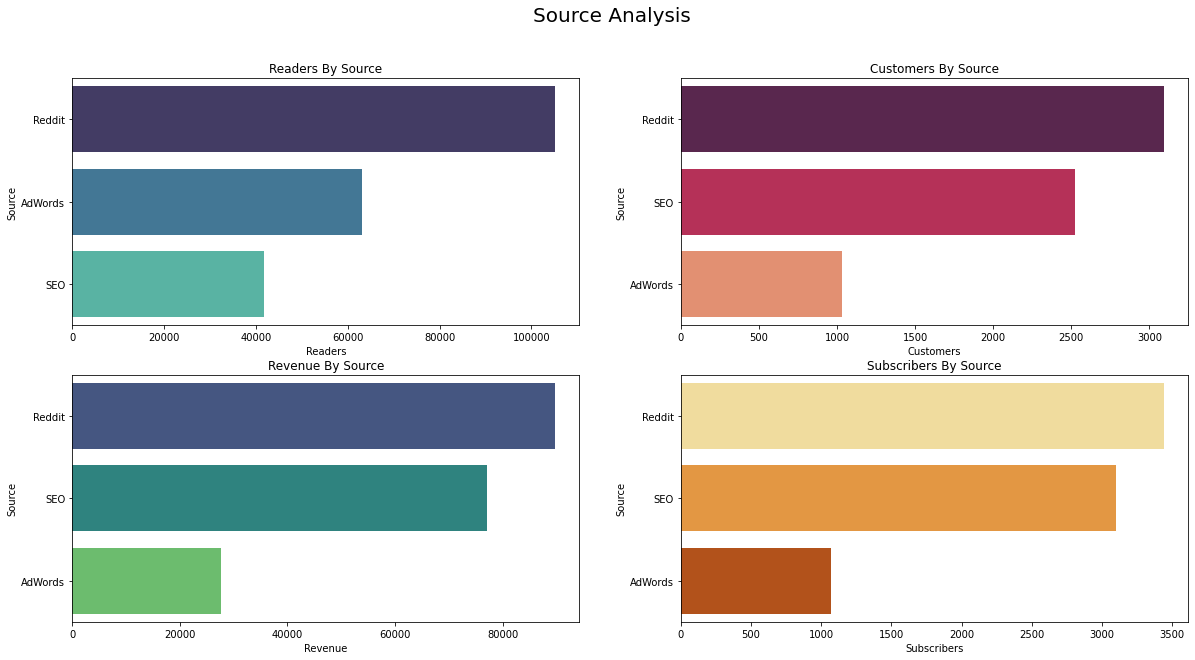

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
fig.suptitle("Source Analysis", fontsize=20)

sns.barplot(y="Source", x="Readers",data=source_data.readers_by_source(), orient='h', palette='mako', ax=axes[0,0])
axes[0,0].set_title("Readers By Source")

sns.barplot(y="Source", x="Customers",data=source_data.customers_by_source(), orient='h', palette='rocket', ax=axes[0,1])
axes[0,1].set_title("Customers By Source")

sns.barplot(y="Source", x="Revenue",data=source_data.revenue_by_source(), orient='h', palette='viridis', ax=axes[1,0])
axes[1,0].set_title("Revenue By Source")

sns.barplot(y="Source", x="Subscribers",data=source_data.subscribers_by_source(), orient='h', palette="YlOrBr", ax=axes[1,1])
axes[1,1].set_title("Subscribers By Source")

#### Conversion rate of each source

In [35]:
# Dataframe with a calculated conversion rate column
source_c_rate = source_data.conversion_rate(source_data.customers_by_source(), source_data.readers_by_source(),\
                                              "Source", "Customers", "Readers").sort_values(by="Conversion", ascending=False)

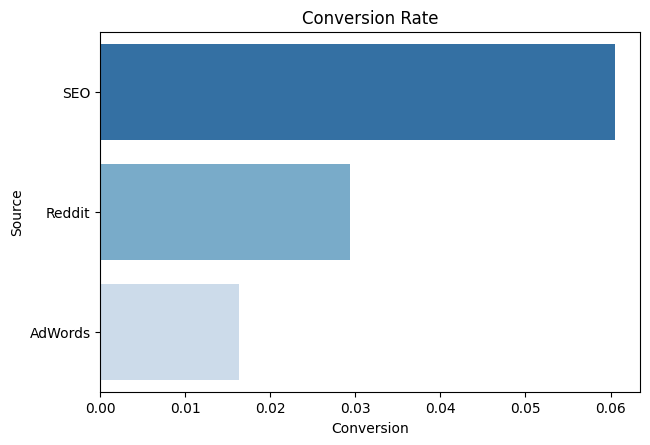

In [36]:
# Using function from the Metrics class to visualize the conversion rate of each source

source_data.horizontal_barplot(source_c_rate,"Conversion Rate", "Conversion", "Source", "Blues_r")

## Segmentation

In [37]:
# Df with the segments

segments = travel_data.segmentation()

In [38]:
# Pivot for the visualization

segment_pivot = segments.pivot(index='Country', columns='Source', values='Revenue')

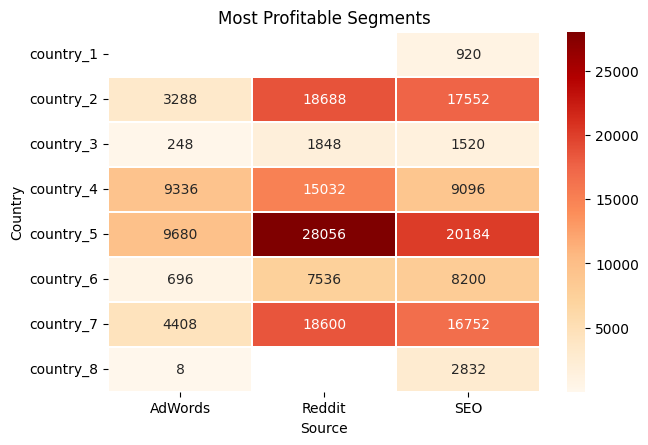

In [47]:
fig = plt.figure(figsize=(6,4), dpi=100)
axes = fig.add_axes([0.1,0.1,0.9,0.9])
axes.set_title("Most Profitable Segments")
sns.heatmap(segment_pivot, annot=True,fmt="g", cmap='OrRd', linewidths=0.5)

## Machine Learning

Creating a random forest model to help with the classification of readers.

#### Transform data for the modeling

I need customer(0 or 1) as the y variable stating if the reader has bought one of the products
The features are: 
- country (the readers nationality), 
- source (which marketing channel brought them here), 
- subscribed (has she subscribed?)
- num_topic (how many of the 6 topics has he read?)
- num_reads (how many times has she read on the blog?)

In [49]:
# df that merges readers and subscribers which gives 3 features already

users = travel_data.readers()[travel_data.readers().source.notnull()][['user_id', 'country', 'source']].reset_index(drop=True)
users = users.merge(travel_data.subscribers(), on='user_id', how='outer')

In [50]:
# subscribers are set to 1, not subscribed set to 0

users['event'] = users['event'].fillna(0)
users['event'] = users['event'].replace(to_replace='subscribe', value = 1)

In [51]:
# creating and merging 'number of topics read' and 'number of reads' features

num_topic = travel_data.readers().groupby('user_id').topic.nunique().reset_index()
num_reads = travel_data.readers().groupby('user_id').count()[['event']].reset_index()
users = users.merge(num_topic, on='user_id')
users = users.merge(num_reads, on='user_id')

In [52]:
# Creating Y variable

users = users.merge(travel_data.customers()[['user_id', 'event']], on= 'user_id', how = 'outer')
users['event'] = users['event'].fillna(0)
users['event'] = users['event'].replace(to_replace='buy', value = 1)

In [53]:
# Remove unnecessary columns

users = users.drop(['event_date', 'event_time'], axis=1)

In [54]:
users.columns = ['user_id', 'country', 'source', 'subscribed', 'num_topic', 'num_reads', 'customer']

In [55]:
# Creating dictionaries for mapping

source_dictionary = {'Reddit': 0, 'AdWords': 1, 'SEO': 2}
country_dictionary = {'country_1': 0, 'country_2': 1,'country_3': 2, 'country_4': 3, 'country_5': 4, 'country_6': 5,
                     'country_7': 6, 'country_8': 7}

In [56]:
# map the columns with categorical variables

users['source'] = users['source'].map(source_dictionary)
users['country'] = users['country'].map(country_dictionary)

In [57]:
users

,user_id,country,source,subscribed,num_topic,num_reads,customer
0,2.458151e+09,6,2,0,1,1,0
1,2.458151e+09,6,2,0,1,1,0
2,2.458151e+09,6,1,0,1,1,0
3,2.458151e+09,6,1,0,1,1,0
4,2.458151e+09,7,0,0,1,1,0
...,...,...,...,...,...,...,...
211777,2.458361e+09,0,2,0,1,1,0
211778,2.458361e+09,5,1,0,1,1,0
211779,2.458361e+09,7,1,0,1,1,0
211780,2.458361e+09,4,1,0,1,1,0


#### Modeling

In [58]:
# setting variables for the model

y = users['customer']
X = users[['country', 'source', 'subscribed', 'num_topic', 'num_reads']]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [60]:
forest = RandomForestClassifier(n_estimators = 100)
forest.fit(X_train, y_train)

RandomForestClassifier()

In [61]:
y_pred_test = forest.predict(X_test)

#### Validation

In [62]:
# checking accuracy

accuracy_score(y_test, y_pred_test)

0.9878555509386923

In [63]:
confusion_matrix(y_test, y_pred_test)

array([[50595,   249],
       [  394,  1708]])

In [64]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     50844
           1       0.87      0.81      0.84      2102

    accuracy                           0.99     52946
   macro avg       0.93      0.90      0.92     52946
weighted avg       0.99      0.99      0.99     52946



In [65]:
importance = forest.feature_importances_
print(importance)

[0.02063242 0.00822286 0.30248662 0.1246876  0.5439705 ]
